In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from aesara import tensor as at

from numpy.random import default_rng
from scipy.special import expit as invlogit

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 15.1

In [4]:
# Simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = rng.integers(3)
    sides = np.array([[1, 1], [1, 0], [0, 0]])[pancake]
    return rng.permutation(sides)


# Simulate 10,000 pancakes
pancakes = np.array([sim_pancake() for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]

# Compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up == 1)
num_11 = np.sum((up == 1) & (down == 1))
print(f"P(burnt down | burnt up) = {round(num_11 / num_11_10, 2)}")

P(burnt down | burnt up) = 0.66


#### Code 15.2

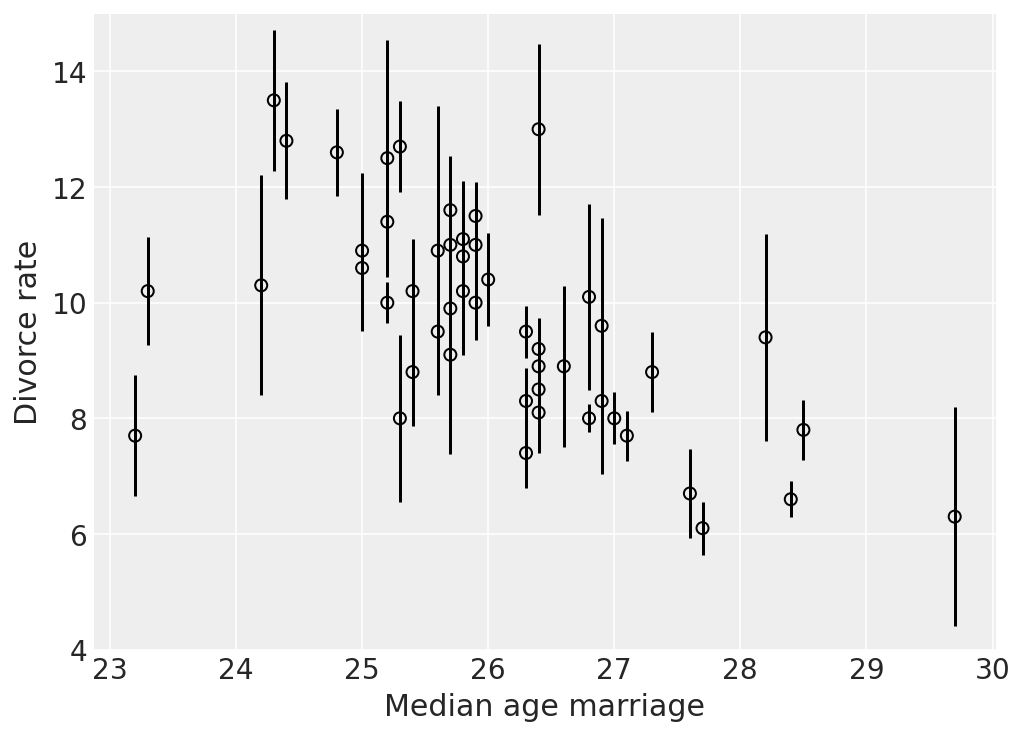

In [5]:
d = pd.read_csv("Data/WaffleDivorce.csv", ";")

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(d["MedianAgeMarriage"], d["Divorce"], edgecolor="k", facecolor="none")
ax.errorbar(d["MedianAgeMarriage"], d["Divorce"], yerr=d["Divorce SE"], fmt="none", c="k")

ax.set_ylim(4, 15)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

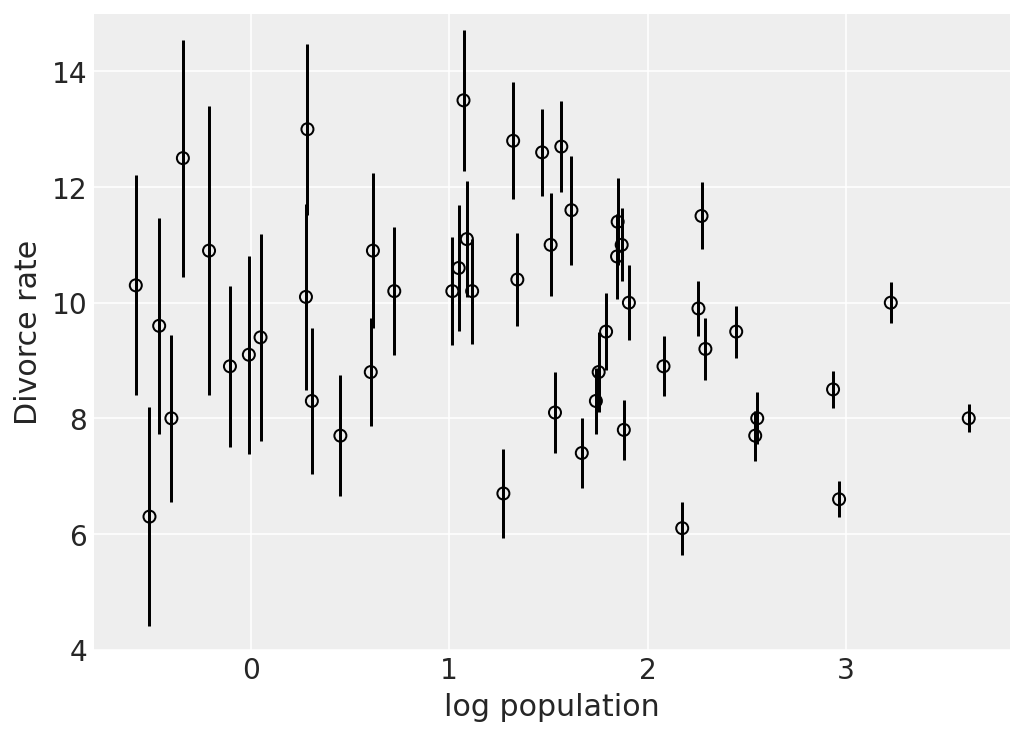

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(np.log(d["Population"]), d["Divorce"], edgecolor="k", facecolor="none")
ax.errorbar(np.log(d["Population"]), d["Divorce"], yerr=d["Divorce SE"], fmt="none", c="k")

ax.set_ylim(4, 15)
ax.set_xlabel("log population")
ax.set_ylabel("Divorce rate");

#### Code 15.3

In [7]:
D_obs = standardize(d["Divorce"].values)
D_sd = d["Divorce SE"].values / d["Divorce"].std()
M = standardize(d["Marriage"].values)
A = standardize(d["MedianAgeMarriage"].values)
N = len(d)

with pm.Model() as m15_1:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = a + bA * A + bM * M  # linear model to assess A -> D
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true values

    D = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)  # distribution for observed values

    trace_m15_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a, D_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


#### Code 15.4

In [8]:
az.summary(trace_m15_1, var_names=["~D_true"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.05,0.17,-0.22,0.31,0.0,0.0,1591.99,2151.53,1.0
bA,-0.62,0.16,-0.88,-0.36,0.0,0.0,1458.58,2267.64,1.0
a,-0.05,0.10,-0.21,0.10,0.0,0.0,2677.15,2606.73,1.0
sigma,0.59,0.11,0.42,0.76,0.0,0.0,610.29,469.58,1.0


#### Code 15.5

In [9]:
D_obs = standardize(d["Divorce"].values)
D_sd = d["Divorce SE"].values / d["Divorce"].std()
M_obs = standardize(d["Marriage"].values)
M_sd = d["Marriage SE"].values / d["Marriage"].std()
A = standardize(d["MedianAgeMarriage"].values)
N = len(d)

with pm.Model() as m15_2:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    M_true = pm.Normal("M_true", 0, 1, shape=N)  # distribution for true M values
    mu = a + bA * A + bM * M_true  # linear model
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true D values

    D = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)  # distribution for observed D values
    M = pm.Normal("M_obs", M_true, M_sd, observed=M_obs)  # distribution for observed M values

    trace_m15_2 = pm.sample(random_seed=RANDOM_SEED)

az.summary(trace_m15_2, var_names=["~D_true", "~M_true"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a, M_true, D_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.20,0.20,-0.11,0.54,0.01,0.0,1291.51,2140.15,1.0
bA,-0.54,0.16,-0.77,-0.29,0.00,0.0,1909.43,2791.43,1.0
a,-0.04,0.09,-0.20,0.10,0.00,0.0,2516.82,3013.56,1.0
sigma,0.57,0.11,0.40,0.73,0.00,0.0,789.21,817.41,1.0


#### Code 15.6

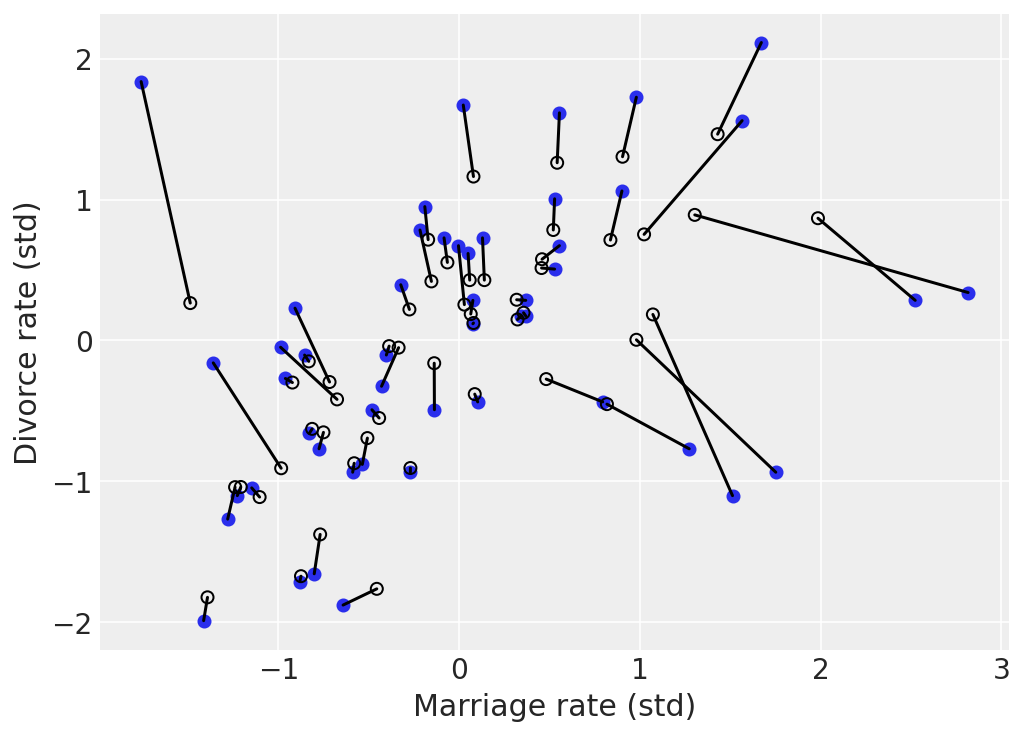

In [10]:
D_true = trace_m15_2.posterior["D_true"].mean(dim=["chain", "draw"])
M_true = trace_m15_2.posterior["M_true"].mean(dim=["chain", "draw"])

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M_obs, D_obs)
ax.scatter(M_true, D_true, edgecolor="k", facecolor="none")
ax.plot([M_obs, M_true], [D_obs, D_true], c="k")

ax.set_xlabel("Marriage rate (std)")
ax.set_ylabel("Divorce rate (std)");

#### Code 15.11

In [11]:
N = 1000  # Number of students
X = rng.normal(size=N)  # Noise of house (unobserved)
S = rng.normal(size=N)  # How much each student studies
H = rng.binomial(
    n=10, p=invlogit(2 + S - 2 * X), size=N
)  # Homework grade affected by study and noise
D = X > 1  # Dogs eat homework in noisy houses

#### Code 15.12

In [12]:
# Model complete dataset

with pm.Model() as m15_3:
    bS = pm.Normal("bS", 0, 0.5)
    a = pm.Normal("a", 0, 1)

    p = pm.invlogit(a + bS * S)  # Model includes study S but not noise X

    Hi = pm.Binomial("Hi", n=10, p=p, observed=H)

    trace_m15_3 = pm.sample(random_seed=RANDOM_SEED)

# The estimate for bS is biased by the unobserved confound X
az.summary(trace_m15_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.62,0.03,0.58,0.66,0.0,0.0,2763.06,2836.67,1.0
a,1.25,0.03,1.21,1.29,0.0,0.0,3095.53,2689.80,1.0


#### Code 15.13

In [13]:
# Model only non-missing data - dogs ate some homework

H_star = H[D == 0]
S_star = S[D == 0]

with pm.Model() as m15_4:
    bS = pm.Normal("bS", 0, 0.5)
    a = pm.Normal("a", 0, 1)

    p = pm.invlogit(a + bS * S_star)

    Hi = pm.Binomial("Hi", n=10, p=p, observed=H_star)

    trace_m15_4 = pm.sample(random_seed=RANDOM_SEED)

# In this case the estimate for bS is a bit closer to the true value of 1
az.summary(trace_m15_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.77,0.03,0.72,0.83,0.0,0.0,2649.46,2359.00,1.0
a,1.85,0.03,1.79,1.90,0.0,0.0,2917.06,2563.95,1.0


#### Code 15.16

In [14]:
d = pd.read_csv("Data/milk.csv", sep=";")
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = np.log(d["mass"])

K = standardize(d["kcal.per.g"]).values
B = standardize(d["neocortex.prop"]).values
M = standardize(d["logmass"]).values

print(f"Number of missing values in B = {np.sum(np.isnan(B))}")

Number of missing values in B = 12


#### Code 15.17

In [15]:
# Impute missing values of B

with pm.Model() as m15_5:
    sigma_B = pm.Exponential("sigma_B", 1)
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    nu = pm.Normal("nu", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    # PyMC automatically imputes missing values
    Bi = pm.Normal("Bi", nu, sigma_B, observed=B)

    mu = a + bB * Bi + bM * M

    Ki = pm.Normal("Ki", mu, sigma, observed=K)

    trace_m15_5 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_m15_5, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_B, sigma, bM, bB, nu, a, Bi_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.54,0.21,-0.88,-0.21,0.00,0.00,2355.19,2563.18,1.0
bB,0.50,0.24,0.14,0.92,0.01,0.00,1631.55,2228.80,1.0
nu,-0.05,0.21,-0.39,0.28,0.00,0.00,4330.07,3660.74,1.0
a,0.03,0.16,-0.22,0.28,0.00,0.00,4907.92,3347.70,1.0
Bi_missing[0],-0.57,0.96,-1.97,1.05,0.01,0.01,4570.25,2901.26,1.0
Bi_missing[1],-0.68,0.96,-2.23,0.77,0.01,0.01,4350.35,2900.76,1.0
Bi_missing[2],-0.70,0.94,-2.23,0.74,0.02,0.01,3968.71,2704.46,1.0
Bi_missing[3],-0.27,0.89,-1.69,1.15,0.01,0.01,5966.95,2993.41,1.0
Bi_missing[4],0.47,0.90,-0.95,1.90,0.01,0.01,5038.20,2951.91,1.0
Bi_missing[5],-0.18,0.89,-1.61,1.20,0.01,0.01,5792.20,2660.21,1.0


#### Code 15.19

In [16]:
# Model only complete cases for comparison with model 15_5

obs_idx = ~d["neocortex.prop"].isna()
K_obs = K[obs_idx]
B_obs = B[obs_idx]
M_obs = M[obs_idx]

with pm.Model() as m15_6:
    sigma_B = pm.Exponential("sigma_B", 1)
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    nu = pm.Normal("nu", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    Bi = pm.Normal("Bi", nu, sigma_B, observed=B_obs)

    mu = a + bB * Bi + bM * M_obs

    Ki = pm.Normal("Ki", mu, sigma, observed=K_obs)

    trace_m15_6 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_m15_6, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_B, sigma, bM, bB, nu, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.64,0.25,-1.04,-0.26,0.0,0.0,2929.04,2818.94,1.0
bB,0.60,0.28,0.17,1.05,0.0,0.0,3208.52,3010.77,1.0
nu,0.00,0.23,-0.37,0.35,0.0,0.0,3307.24,2646.26,1.0
a,0.10,0.20,-0.20,0.41,0.0,0.0,3651.77,2901.55,1.0
sigma_B,1.04,0.19,0.75,1.31,0.0,0.0,3517.15,2562.76,1.0
sigma,0.88,0.18,0.61,1.16,0.0,0.0,2481.68,2443.09,1.0


#### Code 15.20

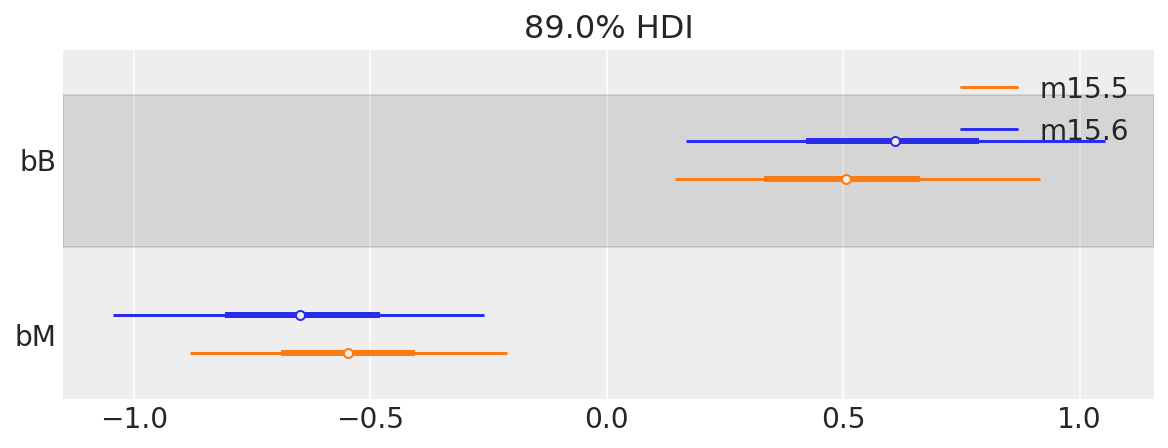

In [17]:
# Model m15.5 (which imputes the missing values) has narrower marginal distributions of bB and bM

az.plot_forest(
    [trace_m15_6, trace_m15_5],
    model_names=["m15.6", "m15.5"],
    var_names=["bB", "bM"],
    combined=True,
    figsize=(8, 3),
);

#### Code 15.21

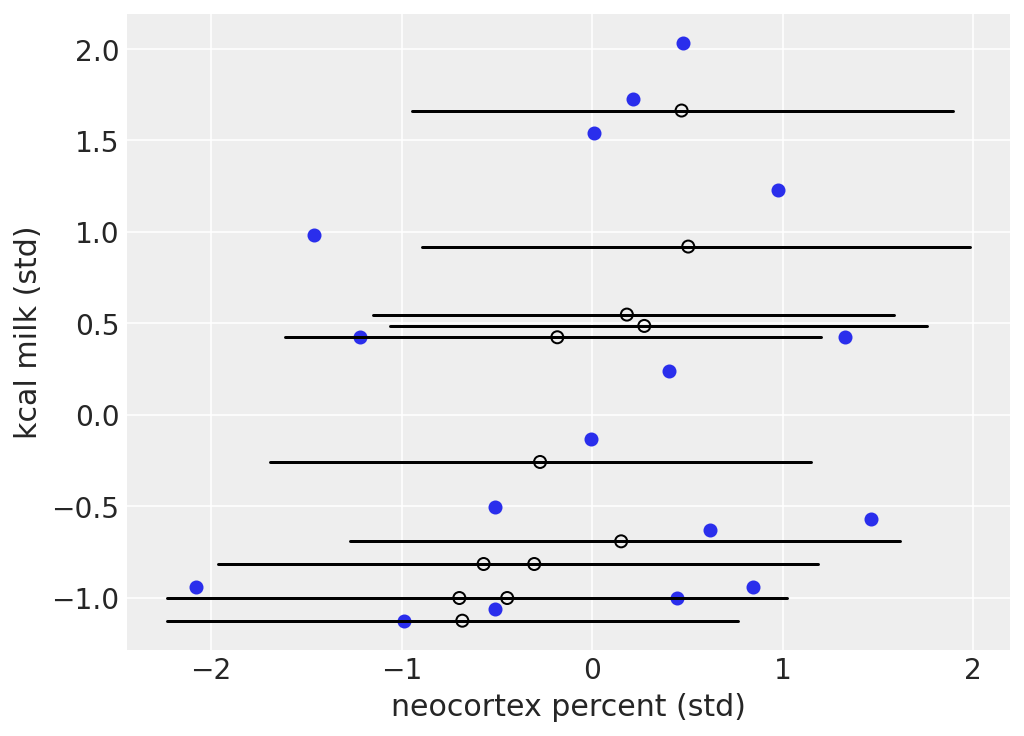

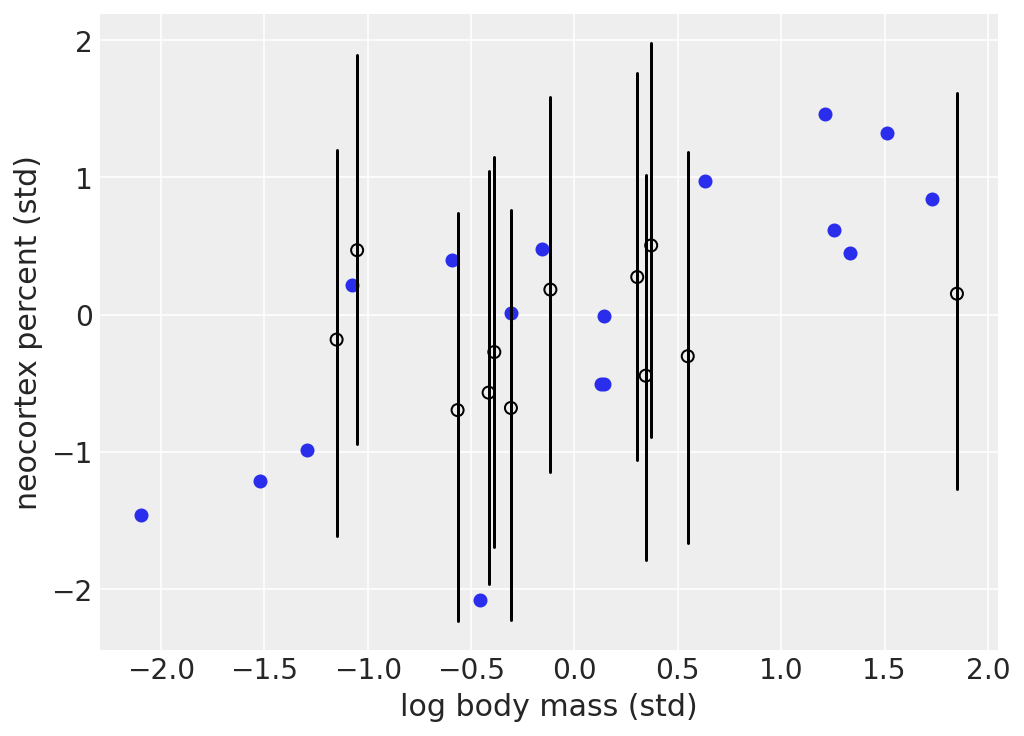

In [18]:
post = trace_m15_5.posterior

# Calculate the posterior mean and hdi for imputed values of B
B_impute_mu = post["Bi_missing"].mean(dim=["chain", "draw"])
B_impute_ci = az.hdi(post, var_names=["Bi_missing"])["Bi_missing"]

# B vs K
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(B, K)
ax.scatter(B_impute_mu, K[~obs_idx], edgecolor="k", facecolor="none")
ax.plot(
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    [K[~obs_idx], K[~obs_idx]],
    color="k",
)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kcal milk (std)")

# M vs B
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M, B)
ax.scatter(M[~obs_idx], B_impute_mu, edgecolor="k", facecolor="none")
ax.plot(
    [M[~obs_idx], M[~obs_idx]],
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    color="k",
)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("neocortex percent (std)");

#### Code 15.22

At the time of this notebook's development, PyMC v4 + does not support automatic imputation for multivariate random variables. Therefore we are unable to unable to build this model and analyze it as in the text. This notebook was originally built in PyMC3, where this multivariate imputation was supported. If you are interested in building the model with PyMC3, you can do so by changing all aesara.tensor refrences (at) to theano.tensor (tt) and add the arguement "return_inferencedata=True" in the pm.sample method.

In [19]:
# Include association between M and B

MB_masked = np.ma.masked_invalid(np.stack([M, B]).T)

with pm.Model() as m15_7:
    sigma = pm.Exponential("sigma", 1)
    muM = pm.Normal("muM", 0, 0.5)
    muB = pm.Normal("muB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1), compute_corr=True
    )

    # M and B correlation
    MB = pm.MvNormal("MB", mu=at.stack([muM, muB]),chol=chol,observed=MB_masked)

    mu = a + bB * MB[:, 1] + bM * M

    Ki = pm.Normal("Ki", mu, sigma, observed=K)

    idata_m15_7 = pm.sample(random_seed=RANDOM_SEED)
    idata_m15_7.rename({"chol_cov_corr": "Rho_MB"},inplace=True)
    
# Strong correlation between M and B
az.summary(idata_m15_7, var_names=["bM", "bB", "Rho_MB"], round_to=2)

NotImplementedError: Automatic inputation is only supported for univariate RandomVariables, but MB is multivariate

In [20]:
try:
    post = idata_m15_7.posterior

    # Calculate the posterior mean and hdi for imputed values of B
    B_impute_mu = post["MB_missing"].mean(dim=["chain", "draw"])
    B_impute_ci = az.hdi(post, var_names=["MB_missing"])["MB_missing"]

    # B vs K
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(B, K)
    ax.scatter(B_impute_mu, K[~obs_idx], edgecolor="k", facecolor="none")
    ax.plot(
        [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
        [K[~obs_idx], K[~obs_idx]],
        color="k",
    )
    ax.set_xlabel("neocortex percent (std)")
    ax.set_ylabel("kcal milk (std)")

    # M vs B
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(M, B)
    ax.scatter(M[~obs_idx], B_impute_mu, edgecolor="k", facecolor="none")
    ax.plot(
        [M[~obs_idx], M[~obs_idx]],
        [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
        color="k",
    )
    ax.set_xlabel("log body mass (std)")
    ax.set_ylabel("neocortex percent (std)");
except:
    print("idata_m15_7 not found")

idata_m15_7 not found


#### Code 15.29

In [21]:
N_houses = 100  # Number of houses to simulate
alpha = 5  # Average number of notes when cat is absent
beta = -3  # Difference in number of notes when cat is present
k_true = 0.5  # Probability of cat present
r = 0.2  # Probability of not knowing whether cat present/absent

cat_true = rng.binomial(n=1, p=k_true, size=N_houses)
notes = rng.poisson(lam=alpha + beta * cat_true, size=N_houses)
R_C = rng.binomial(n=1, p=r, size=N_houses)
cat = cat_true.copy()
cat[R_C == 1] = -9

#### Code 15.30

In [22]:
with pm.Model() as m15_8:
    # priors
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.5)
    k = pm.Beta("k", 2, 2)

    # cat NA
    custom_logp = pm.math.logsumexp(
        pm.math.log(k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes[cat == -9])
        + pm.math.log(1 - k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes[cat == -9])
    )
    # Using pm.Potential to add custom term to model logp
    notes_RC_1 = pm.Potential("notes|RC==1", custom_logp)

    # cat known present/absent
    cat_RC_0 = pm.Bernoulli("cat|RC==0", k, observed=cat[cat != -9])
    lam = pm.math.exp(a + b * cat_RC_0)
    notes_RC_0 = pm.Poisson("notes|RC==0", lam, observed=notes[cat != -9])

    idata_m15_8 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_m15_8, var_names=["a", "b", "k"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.55,0.07,1.45,1.66,0.0,0.0,3800.05,3363.02,1.0
b,-1.07,0.14,-1.30,-0.85,0.0,0.0,3882.64,3246.86,1.0
k,0.42,0.06,0.33,0.51,0.0,0.0,5253.38,2672.58,1.0


In [23]:
print(f"a from data generating process = {round(np.log(alpha), 2)}")
print(f"b from data generating process = {round(np.log(alpha+beta)-np.log(alpha), 2)}")
print(f"k from data generating process = {k_true}")

a from data generating process = 1.61
b from data generating process = -0.92
k from data generating process = 0.5


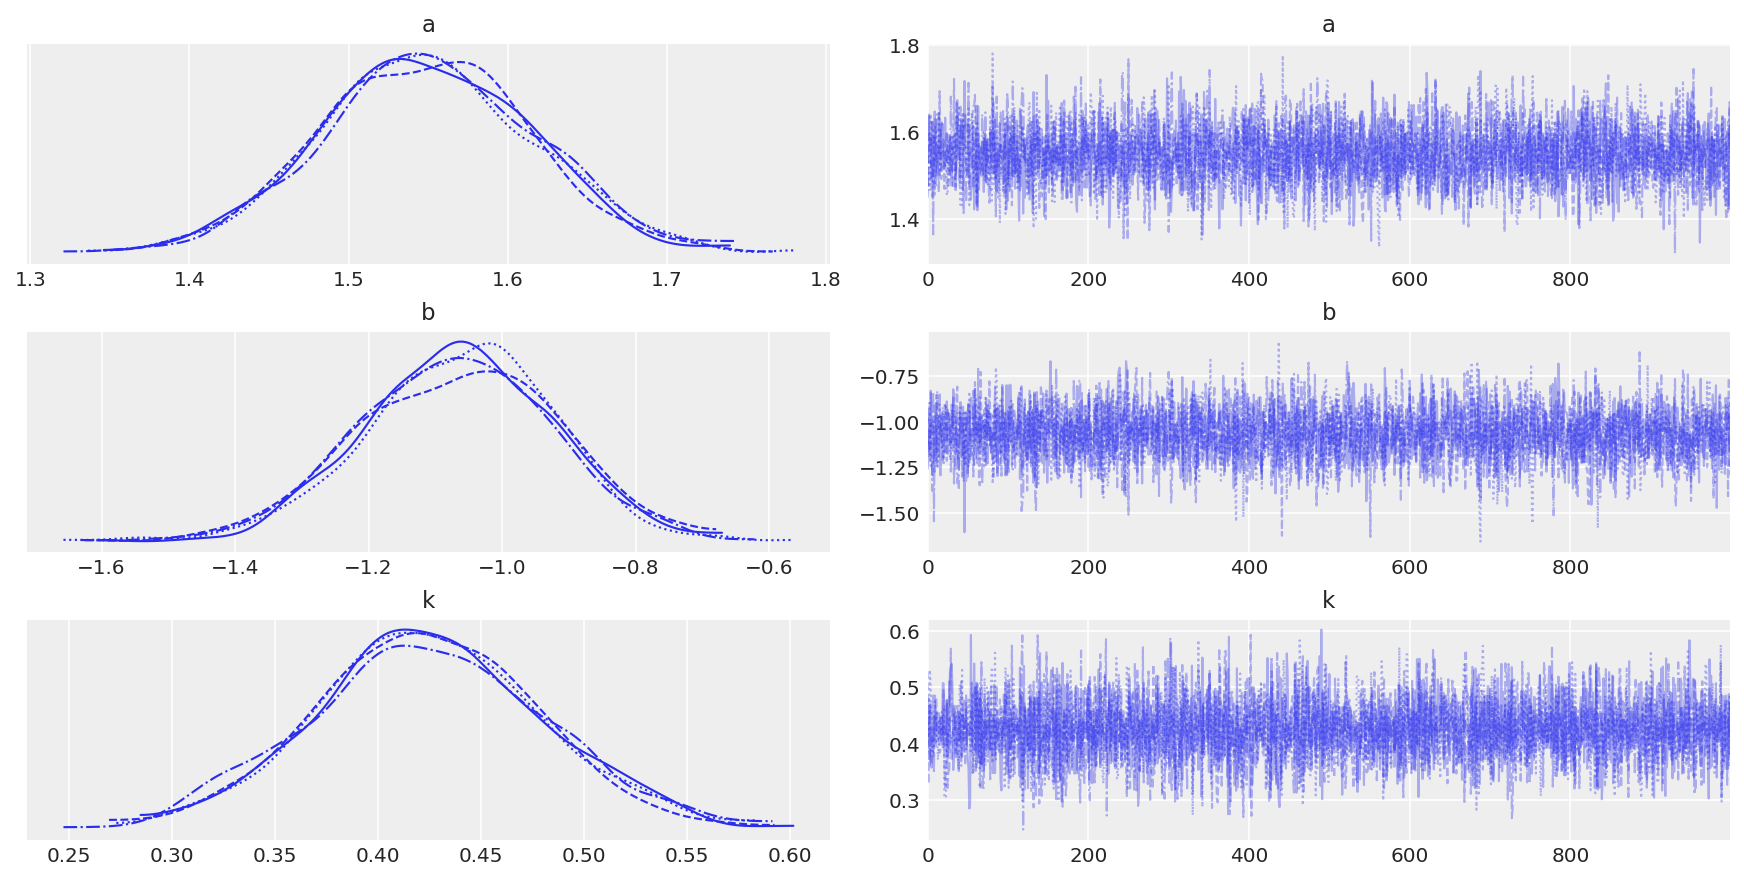

In [24]:
az.plot_trace(idata_m15_8, var_names=["a", "b", "k"]);

#### Code 15.31

In [25]:
with pm.Model() as m15_9:
    # priors
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.5)
    k = pm.Beta("k", 2, 2)

    # cat NA
    custom_logp = pm.math.logsumexp(
        pm.math.log(k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes[cat == -9])
        + pm.math.log(1 - k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes[cat == -9])
    )
    notes_RC_1 = pm.Potential("notes|RC==1", custom_logp)

    # cat known present/absent
    cat_RC_0 = pm.Bernoulli("cat|RC==0", k, observed=cat[cat != -9])
    lam = pm.math.exp(a + b * cat_RC_0)
    notes_RC_0 = pm.Poisson("notes|RC==0", lam, observed=notes[cat != -9])

    # imputed values
    lpC0 = pm.Deterministic(
        "lpC0", pm.math.log(1 - k) + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes)
    )
    lpC1 = pm.Deterministic(
        "lpC1", pm.math.log(k) + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes)
    )
    PrC1 = pm.Deterministic("PrC1", pm.math.exp(lpC1) / (pm.math.exp(lpC1) + pm.math.exp(lpC0)))

    idata_m15_9 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_m15_9, var_names=["a", "b", "k"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.55,0.07,1.45,1.66,0.0,0.0,3800.05,3363.02,1.0
b,-1.07,0.14,-1.30,-0.85,0.0,0.0,3882.64,3246.86,1.0
k,0.42,0.06,0.33,0.51,0.0,0.0,5253.38,2672.58,1.0


In [26]:
# Posterior P(C==1|N)
PrC1_hdi = az.hdi(idata_m15_9.posterior["PrC1"])["PrC1"]

# For display purposes, sort by whether the cat was absent or present
sorted_cats = np.argsort(cat_true)
cat_true_sorted = cat_true[sorted_cats]
PrC1_hdi_sorted = PrC1_hdi[sorted_cats]
cat_obs_sorted = cat[sorted_cats]

# We will give a different colour to cases where we don't know if the cat is there
cat_obs_sorted[cat_obs_sorted == -9] = 2

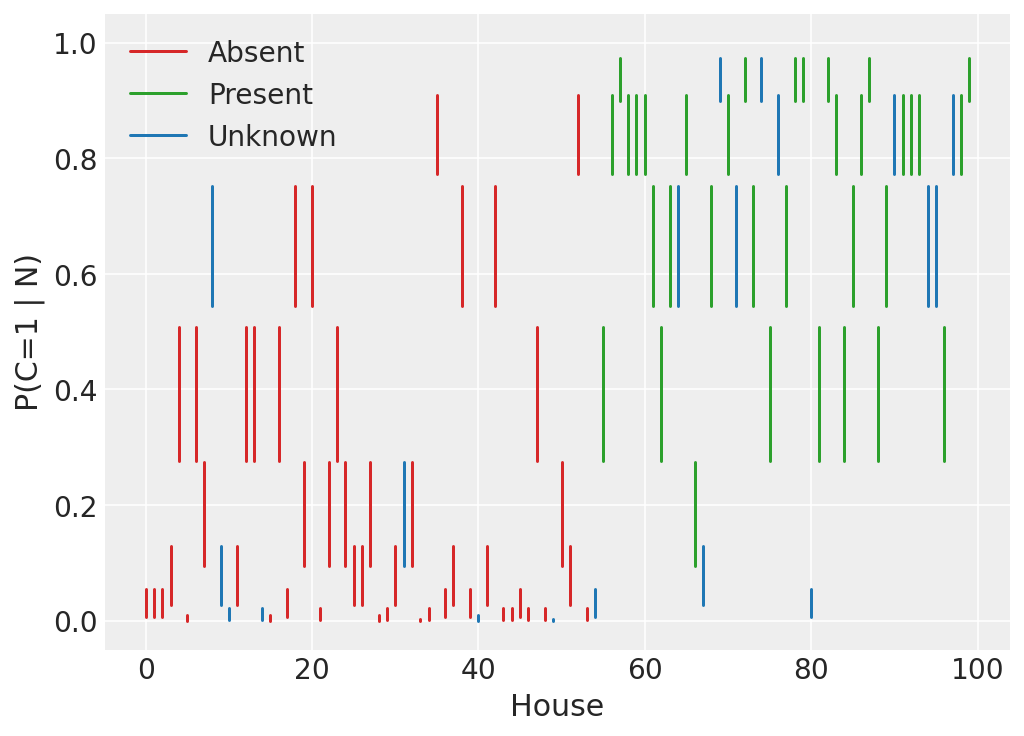

In [27]:
# Plot P(C==1 | N) for each house

labels = ["Absent", "Present", "Unknown"]
colours = ["tab:red", "tab:green", "tab:blue"]

fig, ax = plt.subplots(figsize=(7, 5))
for i in range(3):
    idx = cat_obs_sorted == i
    ax.plot(
        [np.flatnonzero(idx), np.flatnonzero(idx)],
        [PrC1_hdi_sorted[idx, 0], PrC1_hdi_sorted[idx, 1]],
        color=colours[i],
    )
    # Trick to have one label per group
    ax.axhline(2, color=colours[i], alpha=1, label=labels[i])

ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("House")
ax.set_ylabel("P(C=1 | N)")
ax.legend();

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 17 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

matplotlib: 3.5.2
numpy     : 1.22.1
arviz     : 0.12.1
pandas    : 1.4.2
pymc      : 4.0.0
aesara    : 2.6.6

Watermark: 2.3.1

